# Agentic Care Coordinator (OpenAI v1.x API)
This notebook demonstrates how to use OpenAI's new Python client (v1.x+) to build an agentic assistant for healthcare care coordination.

#Requirement Description: Agentic Care Coordinator

##Project Title:

Agentic Care Coordinator AI-powered Clinical Workflow Assistant



### Overview:

The Agentic Care Coordinator is an AI-driven assistant designed to streamline the care coordination process across fragmented healthcare systems. It autonomously integrates patient data from multiple sources, identifies care gaps, and generates actionable messages for healthcare providers and patients using natural language capabilities powered by OpenAI’s GPT.



### Goals and Objectives:


1. Automate the aggregation and summarization of multi-source patient health data.
2. Use a generative AI agent to identify care coordination issues such as overdue tests, unmanaged chronic conditions, and follow-up gaps.
3. Generate professional, contextual messages for providers and simplified, patient-friendly messages for recipients.
2. Reduce administrative burden and enhance decision-making through agentic intelligence.



### Functional Requirements:

1. Data Aggregation Module
	•	Inputs:
	•	Electronic Health Record (EHR): diagnoses, medications, last visit
	•	Lab results: test names, values (e.g., HbA1c), dates
	•	Pharmacy: current prescriptions, refill status
	•	Patient self-reported data: symptoms, appointment history
	•	Output: Unified patient record in structured dictionary format.

2. Summary Generator
	•	Converts structured patient record into a readable summary using predefined templates.
	•	Example:
“Patient diagnosed with Type 2 Diabetes is on Metformin. Latest HbA1c: 9.1. Reports symptoms of fatigue. No upcoming appointments scheduled.”

3. GPT Agent Layer
	•	Integrates OpenAI GPT-4 API to:
	•	Detect care gaps
	•	Draft provider communication
	•	Generate empathetic patient messages
	•	Messages are context-aware, role-specific, and generated through structured prompts.

4. Care Gap Detection
	•	Identify:
	•	Lack of scheduled appointments
	•	High lab values (e.g., elevated HbA1c)
	•	No active prescriptions or exhausted refills

5. Communication Generator
	•	Provider Messaging:
	•	Formal tone
	•	Medical risk framing
	•	Action recommendations
	•	Patient Messaging:
	•	Layman-friendly
	•	Encouraging tone
	•	Clear instructions

### Non-Functional Requirements:    
*   Performance - API calls to GPT should respond within 2–5 seconds  per request
*   Security - Must not log or expose any PHI; use masked/demo data during dev
*   Scalability - Modular agent architecture to support adding more roles (e.g., triage, scheduling)
*   	Availability -99.9% uptime (if deployed in production with a web UI or API)
*   Compliance (Optional) - HIPAA-compliant backend for production deployment

###  User Roles:
*   Healthcare Provider - Review provider alerts/messages, act on recommendations
*   Patient - Receive simplified instructions, schedule follow-ups
*   Admin/Analyst - Monitor system performance, update GPT prompt templates

###  Integration Points:
*   OpenAI GPT-4 API
*   Optional: EHR or FHIR-compliant systems (for real-time data ingestion)
*   	Calendar/Scheduling APIs (e.g., Google Calendar, Outlook)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


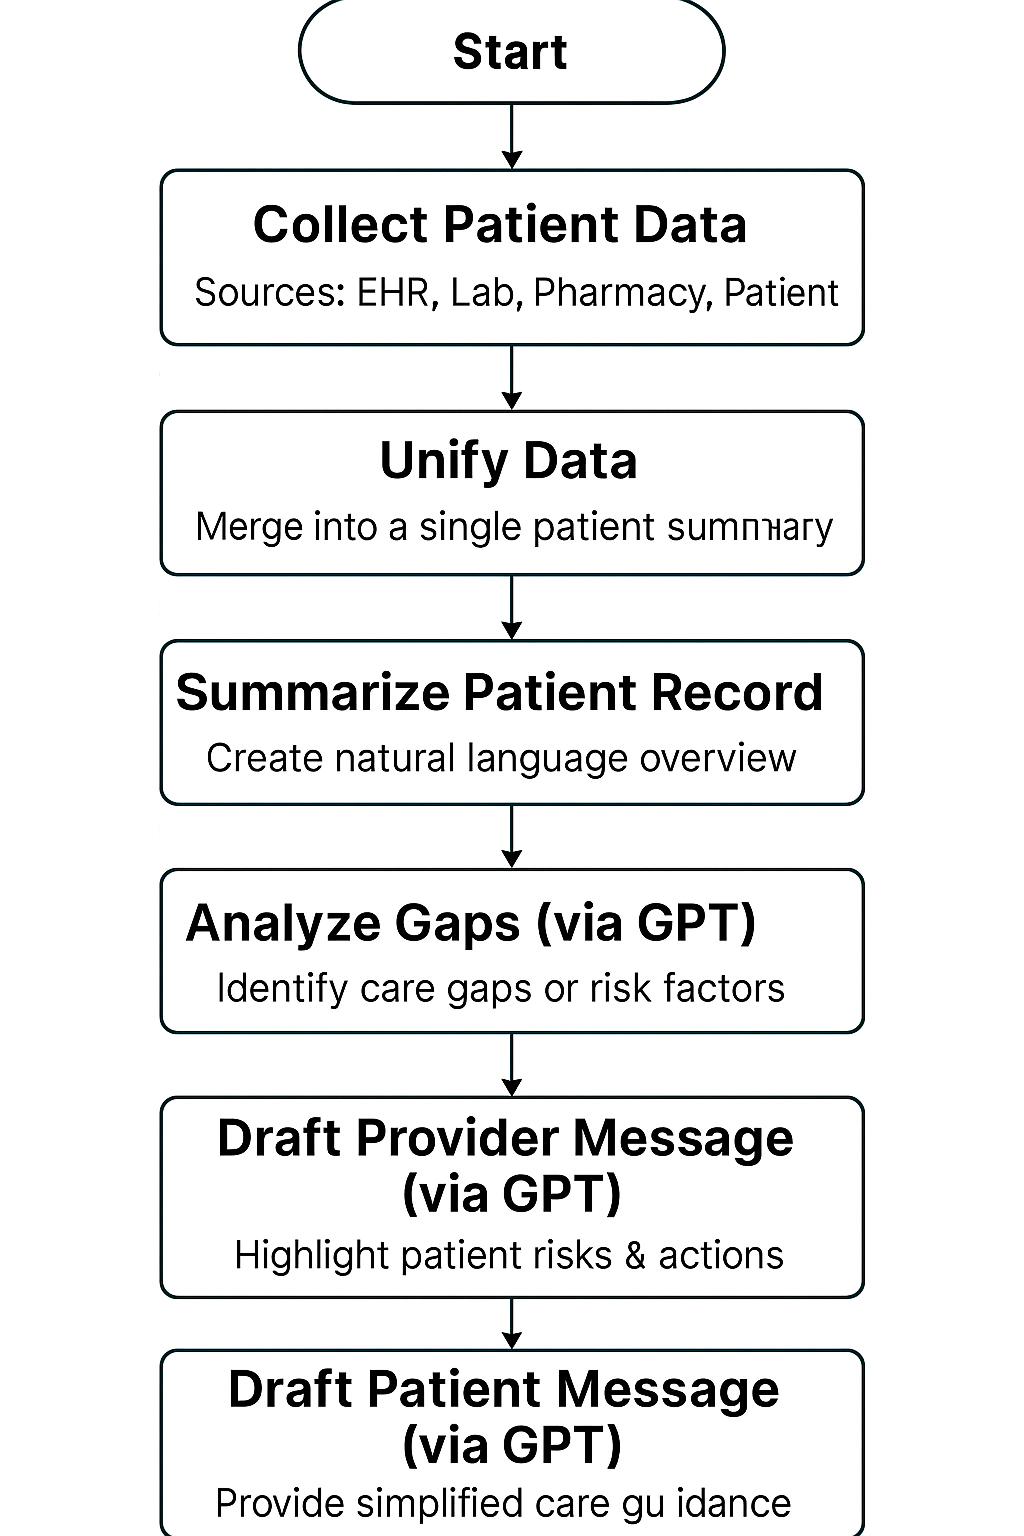

In [29]:
from google.colab import drive
drive.mount('/content/drive')

from IPython.display import Image
Image('/content/drive/MyDrive/agentic care coordinator image.png')

In [ ]:
# Install OpenAI client (v1.x or later)
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.3/683.3 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.78.1
    Uninstalling openai-1.78.1:
      Successfully uninstalled openai-1.78.1


Mounted at /content/drive


In [ ]:
# Get the OpenAI api key from env variable
from google.colab import userdata
from openai import OpenAI

# Fetch secret securely
api_key = userdata.get('OPENAI_API_KEY')

# Fallback in case secret is not set
if not api_key:
    raise ValueError("OPENAI_API_KEY is not available in Colab secrets.")

# Set up OpenAI client with api key
client = OpenAI(api_key=api_key)

In [ ]:
import json

# Generate dummy patient data

def generate_patient_data():
    prompt = (
        "Create a JSON object simulating structured patient data across the following sources: "
        "EHR (diagnoses, medications, last_visit), Lab (HbA1c, last_test), "
        "Pharmacy (active_prescriptions, refills_left), and Patient (reported_symptoms, next_appointment). "
        "Ensure it's consistent and realistic for a chronic condition like Type 2 Diabetes."
    )

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a medical data generator for healthcare applications."},
            {"role": "user", "content": prompt}
        ]
    )

    content = response.choices[0].message.content.strip()
    try:
        # Remove code block syntax if present
        if "```" in content:
            content = content.split("```")[1].replace("json", "").strip()
        data = json.loads(content)
    except json.JSONDecodeError:
        raise ValueError("Failed to parse AI-generated JSON. Response was:\n" + content)

    return data

In [ ]:
# Generate summary and call GPT

def synthesize_agent_response(data_summary: str, task: str) -> str:
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert care coordinator AI agent."},
            {"role": "user", "content": f"Given the following summary of a patient's record: {data_summary}. Please {task}."}
        ]
    )
    return response.choices[0].message.content.strip()

In [ ]:
# Run the care coordinator agent

def run_agent(sources):
    print("\n Running care coordination agent with OpenAI integration...\n")

    # Merge data into a flat record
    unified_record = {}
    for source in sources.values():
        unified_record.update(source)

    # Safely access fields (with default values)
    summary = (
        f"Patient diagnosed with {unified_record.get('diagnoses', [])} is on medications {unified_record.get('medications', [])}. "
        f"The most recent HbA1c value is {unified_record.get('HbA1c', 'unknown')}, and the patient reports symptoms of {unified_record.get('reported_symptoms', [])}. "
        f"There are {unified_record.get('refills_left', 'N/A')} prescription refills left. "
        f"The next appointment is scheduled for {unified_record.get('next_appointment', 'not scheduled')}."
    )

    print(" Summary:\n", summary)

    # Generate care gaps
    gaps = synthesize_agent_response(summary, "identify potential care gaps or coordination issues")
    print("\n Care Gaps Identified:\n", gaps)

    # Generate provider message
    provider_msg = synthesize_agent_response(summary, "draft a message to notify the care provider about patient risks and recommended actions")
    print("\n Provider Message:\n", provider_msg)

    # Generate patient message
    patient_msg = synthesize_agent_response(summary, "create a friendly and clear message to the patient explaining what actions they need to take")
    print("\n Patient Message:\n", patient_msg)

In [ ]:
# print data content

patient_data_sources = generate_patient_data()
print(" Populated patient_data_sources:\n")
print(json.dumps(patient_data_sources, indent=2))



 Populated patient_data_sources:

{
  "Patient": {
    "first_name": "John",
    "last_name": "Doe",
    "dob": "1964-05-16",
    "reported_symptoms": {
      "date_reported": "2021-09-20",
      "symptom_list": [
        "Increased thirst",
        "Frequent urination",
        "Unintended weight loss",
        "Fatigue"
      ],
      "severity": "medium"
    },
    "next_appointment": "2021-12-15"
  },
  "EHR": {
    "diagnoses": {
      "number_of_diagnoses": 1,
      "diagnoses_list": [
        {
          "code": "E11.9",
          "description": "Type 2 diabetes mellitus without complications",
          "date": "2020-10-04"
        }
      ]
    },
    "medications": [
      {
        "name": "Metformin",
        "dosage": "1000 mg",
        "frequency": "twice daily",
        "start_date": "2020-10-06"
      }
    ],
    "last_visit": "2021-09-20"
  },
  "Lab": {
    "tests": [
      {
        "name": "HbA1c",
        "result": "7.5%",
        "date": "2021-09-20",
        "un

In [ ]:
# Execute
run_agent(patient_data_sources)


 Running care coordination agent with OpenAI integration...

 Summary:
 Patient diagnosed with {'number_of_diagnoses': 1, 'diagnoses_list': [{'code': 'E11.9', 'description': 'Type 2 diabetes mellitus without complications', 'date': '2020-10-04'}]} is on medications [{'name': 'Metformin', 'dosage': '1000 mg', 'frequency': 'twice daily', 'start_date': '2020-10-06'}]. The most recent HbA1c value is unknown, and the patient reports symptoms of {'date_reported': '2021-09-20', 'symptom_list': ['Increased thirst', 'Frequent urination', 'Unintended weight loss', 'Fatigue'], 'severity': 'medium'}. There are 5 prescription refills left. The next appointment is scheduled for 2021-12-15.

 Care Gaps Identified:
 1. Recording of HbA1c Values: The most recent HbA1c value of the patient is unknown. Regular monitoring of HbA1c is critical in diabetes management to assess the patient's overall sugar control over a period of approximately 3 months. The value helps in deciding whether the management pla